<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Chest%20X_Ray/TL_for_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, MobileNetV2
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [13]:
# ----------------------------
# 1. Mount Google Drive
# ----------------------------
from google.colab import drive
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

# ----------------------------
# 2. Reproducibility
# ----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ----------------------------
# 3. Data & Parameters
# ----------------------------
DATA_DIR = '/content/drive/MyDrive/Chest X_Ray'  # root dataset folder
OUTPUT_DIR = '/content/Chest_XRay_split'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

EPOCHS = 5

LEARNING_RATE = 1e-4
N_CLASSES = 2
MAX_IMAGES_PER_CLASS = 1000  # update if needed

# Split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# ----------------------------
# 4. Create directories
# ----------------------------
train_dir = os.path.join(OUTPUT_DIR, 'train')
val_dir = os.path.join(OUTPUT_DIR, 'val')
test_dir = os.path.join(OUTPUT_DIR, 'test')

for folder in [train_dir, val_dir, test_dir]:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# ----------------------------
# 5. Split dataset
# ----------------------------
for cls in ['NORMAL', 'PNEUMONIA']:
    cls_dir = os.path.join(DATA_DIR, cls)
    images = [img for img in os.listdir(cls_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))][:MAX_IMAGES_PER_CLASS]

    train_imgs, temp_imgs = train_test_split(images, test_size=(1-TRAIN_RATIO), random_state=SEED)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=TEST_RATIO/(TEST_RATIO + VAL_RATIO), random_state=SEED)

    # Copy images to train/val/test
    for img in train_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))

print("Dataset split completed successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset split completed successfully!


In [14]:
def create_fixed_split(data_dir):
    images, labels = [], []

    for label in sorted(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, label)
        for img in os.listdir(class_dir):
            images.append(os.path.join(class_dir, img))
            labels.append(label)

    df = pd.DataFrame({"filename": images, "class": labels})
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    n = len(df)
    train_end = int(n * TRAIN_RATIO)
    val_end = int(n * (TRAIN_RATIO + VAL_RATIO))

    return (
        df.iloc[:train_end],
        df.iloc[train_end:val_end],
        df.iloc[val_end:]
    )

train_df, val_df, test_df = create_fixed_split(DATA_DIR)


In [15]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_data = test_gen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


In [16]:
def build_model(base_model):
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(N_CLASSES, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [17]:
def train_model(model):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        verbose=1
    )
    return history

In [18]:
def evaluate_model(model, test_data):
    y_true = test_data.classes
    y_prob = model.predict(test_data)
    y_pred = np.argmax(y_prob, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(classification_report(y_true, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


===== VGG16 =====


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 122s 927ms/step - accuracy: 0.6905 - loss: 0.6215 - val_accuracy: 0.7232 - val_loss: 0.4308
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 112s 871ms/step - accuracy: 0.7757 - loss: 0.4628 - val_accuracy: 0.8428 - val_loss: 0.3461
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 113s 876ms/step - accuracy: 0.8287 - loss: 0.3828 - val_accuracy: 0.9066 - val_loss: 0.2933
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 114s 887ms/step - accuracy: 0.8766 - loss: 0.3171 - val_accuracy: 0.9123 - val_loss: 0.2636
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 113s 875ms/step - accuracy: 0.8880 - loss: 0.2812 - val_accuracy: 0.9191 - val_loss: 0.2418
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 834ms/step


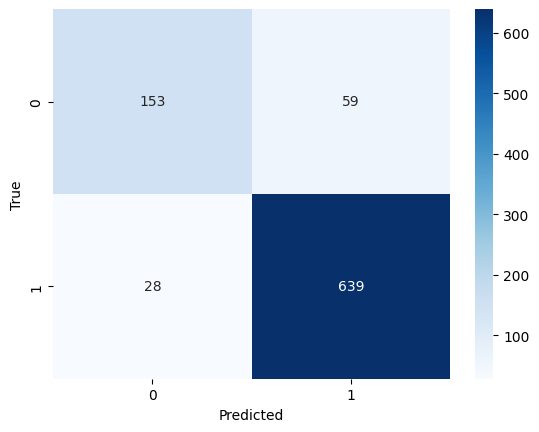

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       212
           1       0.92      0.96      0.94       667

    accuracy                           0.90       879
   macro avg       0.88      0.84      0.86       879
weighted avg       0.90      0.90      0.90       879



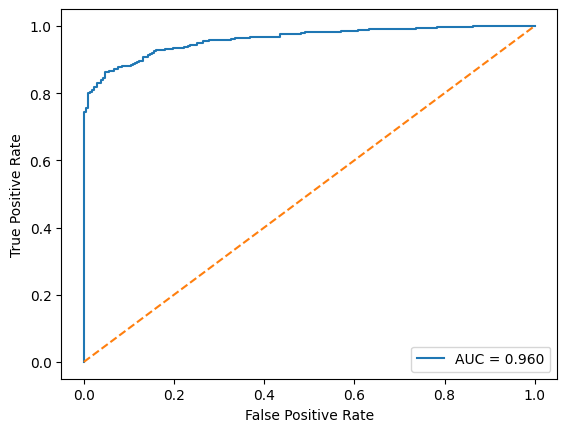


===== ResNet50 =====
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 135s 944ms/step - accuracy: 0.6922 - loss: 0.6390 - val_accuracy: 0.7187 - val_loss: 0.5605
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 109s 848ms/step - accuracy: 0.7153 - loss: 0.5857 - val_accuracy: 0.7187 - val_loss: 0.5297
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 110s 850ms/step - accuracy: 0.7298 - loss: 0.5478 - val_accuracy: 0.7187 - val_loss: 0.5043
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 110s 855ms/step - accuracy: 0.7466 - loss: 0.5039 - val_accuracy: 0.7380 - val_loss: 0.4817
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 110s 847ms/step - accuracy: 0.7273 - loss: 0.5091 - val_accuracy: 0.7528 - val_loss: 0.4596
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 596ms/step


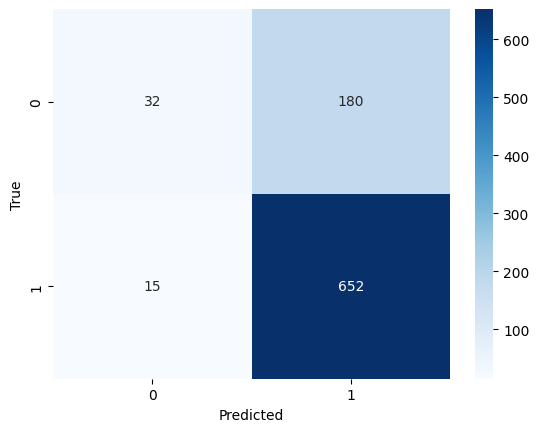

              precision    recall  f1-score   support

           0       0.68      0.15      0.25       212
           1       0.78      0.98      0.87       667

    accuracy                           0.78       879
   macro avg       0.73      0.56      0.56       879
weighted avg       0.76      0.78      0.72       879



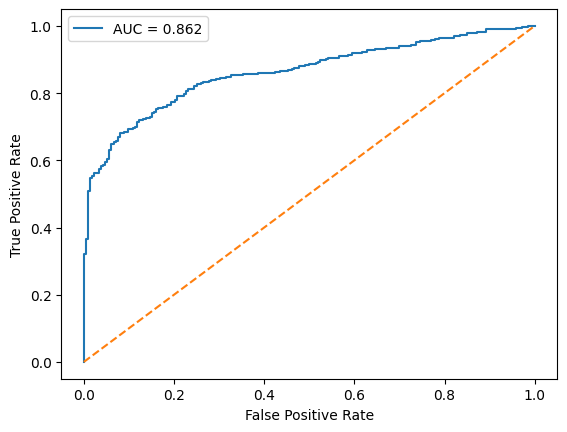


===== InceptionV3 =====
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 147s 997ms/step - accuracy: 0.7886 - loss: 0.4814 - val_accuracy: 0.9180 - val_loss: 0.2070
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 109s 842ms/step - accuracy: 0.8981 - loss: 0.2502 - val_accuracy: 0.9328 - val_loss: 0.1800
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 109s 847ms/step - accuracy: 0.9057 - loss: 0.2152 - val_accuracy: 0.9374 - val_loss: 0.1666
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 109s 845ms/step - accuracy: 0.9134 - loss: 0.2047 - val_accuracy: 0.9260 - val_loss: 0.1824
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 109s 844ms/step - accuracy: 0.9275 - loss: 0.1883 - val_accuracy: 0.9544 - val_loss: 0.1483
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 710ms/step


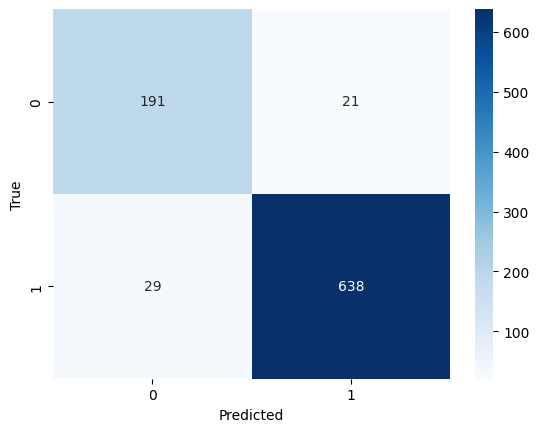

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       212
           1       0.97      0.96      0.96       667

    accuracy                           0.94       879
   macro avg       0.92      0.93      0.92       879
weighted avg       0.94      0.94      0.94       879



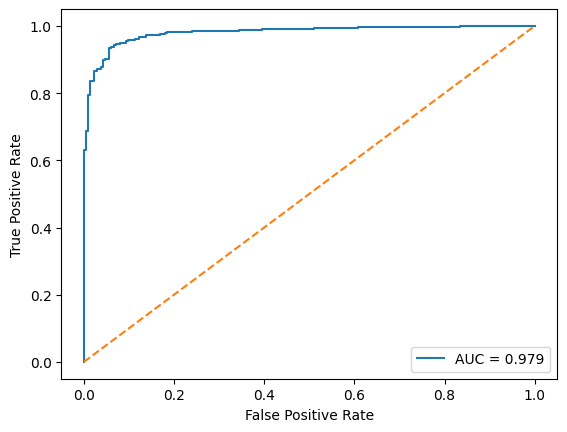


===== MobileNetV2 =====
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7760 - loss: 0.4634 - val_accuracy: 0.9282 - val_loss: 0.1733
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 106s 826ms/step - accuracy: 0.9160 - loss: 0.2136 - val_accuracy: 0.9431 - val_loss: 0.1352
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 106s 823ms/step - accuracy: 0.9215 - loss: 0.1741 - val_accuracy: 0.9601 - val_loss: 0.1123
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 107s 827ms/step - accuracy: 0.9480 - loss: 0.1366 - val_accuracy: 0.9556 - val_loss: 0.1122
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 109s 838ms/step - accuracy: 0.9537 - loss: 0.1256 - val_accuracy: 0.9522 - val_loss: 0.1093
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 823ms/step


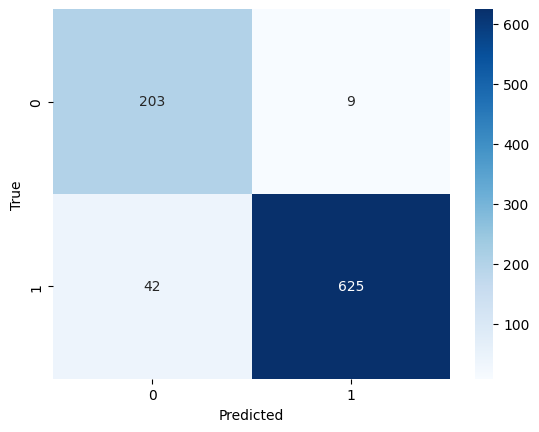

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       212
           1       0.99      0.94      0.96       667

    accuracy                           0.94       879
   macro avg       0.91      0.95      0.92       879
weighted avg       0.95      0.94      0.94       879



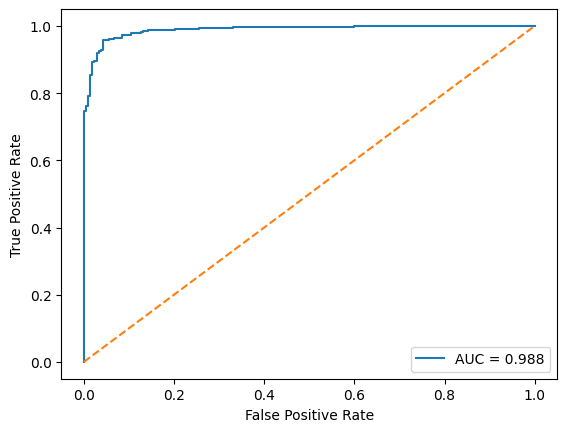

In [19]:
models = {
    "VGG16": VGG16(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3)),
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
}

for name, base in models.items():
    print(f"\n===== {name} =====")
    model = build_model(base)
    train_model(model)
    evaluate_model(model, test_data)


In [ ]:
# =========================
# Statistical Comparison
# =========================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(model, test_data):
    y_true = test_data.classes
    y_prob = model.predict(test_data)
    y_pred = np.argmax(y_prob, axis=1)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="binary"),
        "Recall (Sensitivity)": recall_score(y_true, y_pred, average="binary"),
        "F1-score": f1_score(y_true, y_pred, average="binary"),
        "AUC": auc(*roc_curve(y_true, y_prob[:, 1])[:2])
    }

# Dictionary to store results
results = {}

for name, base in models.items():
    print(f"Evaluating {name} for statistical table...")
    model = build_model(base)
    train_model(model)
    results[name] = compute_metrics(model, test_data)

# Create DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

results_df

Evaluating VGG16 for statistical table...
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 122s 926ms/step - accuracy: 0.6833 - loss: 0.6295 - val_accuracy: 0.7699 - val_loss: 0.4532
Epoch 2/5
127/129 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step - accuracy: 0.7680 - loss: 0.4674

In [ ]:
styled_table = results_df.style.highlight_max(
    axis=0,
    color="lightgreen"
)
styled_table